# Integration of Online Learning techniques in ErNESTO

In [1]:
import pandas as pd

This notebook serves as a basis to develop the **parameter adaptation layer** for the DT. <br>
This notebook is strongly connected to the repository. Therefore, this script must be mainteined within the _notebook_ folder of the framework.

## Load real-world data: The experiment is for temp = 20

Right now, we have at disposal two ground dataset:
- **ground_20:** parameters check-up dataset (~32700 samples)
- **ground_PV:** photovoltaic profile dataset (~100000 samples)

In [2]:
df = pd.read_csv("ground_20.csv")
df

,current,voltage,temperature,power,time
0,3.9297,4.1482,296.0498,16.301100,0.0
1,3.7463,4.1498,296.0563,15.546702,1.0
2,3.5827,4.1500,296.0306,14.868114,2.0
3,3.4729,4.1500,296.0145,14.412659,3.0
4,3.4159,4.1500,296.0650,14.175813,4.0
...,...,...,...,...,...
32791,0.2797,4.1500,296.5509,1.160901,34039.0
32792,0.2613,4.1500,296.5333,1.084197,34040.0
32793,0.2727,4.1500,296.5776,1.131909,34041.0
32794,0.2908,4.1501,296.5579,1.206755,34042.0


## Instantiate the battery model

In [3]:
# data/config/models/electrical/thevenin.yaml 
electrical_params = {
    'type': 'electrical', 
    'class_name': 'TheveninModel', 
    'components': {
        'r0': {
            'selected_type': 'scalar', 
            'scalar': 0.04, 
        }, 
        'r1': {
            'selected_type': 'scalar', 
            'scalar': 0.01, 
        }, 
        'c': {
            'selected_type': 'scalar', 
            'scalar': 10000.0
        }, 
        'v_ocv': {
            'selected_type': 'lookup', 
            'scalar': 3.7,
            'lookup': {
                'inputs': {
                    'soc': [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]},
                'output': [3.50066702789707,3.53494897815592,3.56510898252161,3.59331470182294,3.61667561341815,3.63806205584377,3.65277962751219,3.66782635750825,3.68448386705385,3.70214566116145,3.7278881561918,3.75448648951934,3.79678584989904,3.83908521027874,3.88755653595633,3.93607413747301,3.98259785444942,4.02897955883005,4.08245425955629,4.13694678775337, 4.14365] }
            # TODO: HERE YOU HAVE TO PASS A LINK, NOT THE VALUE BY HAND!
                
        }
    }
}

# data/config/models/thermal/r2c_thermal.yaml
thermal_params = {
    'type': 'thermal', 
    'class_name': 'R2CThermal', 
    'components': {
        'c_term': {
            'selected_type': 'scalar', 
            'scalar': 410
        }, 
        'r_cond': {
            'selected_type': 'scalar', 
            'scalar': 0.000784
        }, 
        'r_conv': {
            'selected_type': 'scalar', 
            'scalar': 2.73
        }, 
        'dv_dT': {
            'selected_type': 'lookup', 
            'scalar': 0.1, 
            'lookup': {
                'inputs': {
                    'soc': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]}, 
                'output': [8e-05, 6e-05, 8e-05, 5e-05, 0.0001, 0.00018, 0.00016, 8e-05, -5e-05, -0.00016, -0.0007]}
        }
    }
}

models_config = [electrical_params, thermal_params]

In [4]:
battery_options = {
    'sign_convention': 'passive', 
    'params': {
        'nominal_capacity': 20.0, 
        'v_max': 4.15, 
        'v_min': 3.0, 
        'temp_ambient': 295.15
    }, 
    'init': {
        'voltage': 3.76, 
        'current': 0.0, 
        'temperature': 295.15, 
        'soc': 0.66, 
        'soh': 1.0
    }
}

In [5]:
from matplotlib import pyplot as plt
from src.digital_twin.bess import BatteryEnergyStorageSystem

In [6]:
load_var = 'current'

In [7]:
battery = BatteryEnergyStorageSystem(
    models_config=models_config,
    battery_options=battery_options,
    input_var=load_var
)

[model.name for model in battery.models]

['Thevenin', 'R2C_thermal']

In [8]:
## Optimizer

In [9]:
import numpy as np
from scipy.optimize import minimize

class Optimizer:
    def __init__(self):
        # Initialize attributes
        self.dt = None
        self.v_batch = None
        self.vocv_batch = None
        self.i_batch = None
        self.bounds = None
        self.batch_size = None
        self.initial_guess = None
        
        

    def set_parameters(self, dt, v_batch, vocv_batch, i_batch, bounds, batch_size):
        # Set or update attributes
        self.dt = dt
        self.v_batch = v_batch
        self.vocv_batch = vocv_batch
        self.i_batch = i_batch
        self.bounds = bounds
        self.batch_size = batch_size

        # Generate initial guess within bounds
        self.initial_guess = np.array([np.random.uniform(low, high) for low, high in self.bounds])
        while not all(low <= val <= high for val, (low, high) in zip(self.initial_guess, self.bounds)):
            self.initial_guess = np.array([np.random.uniform(low, high) for low, high in self.bounds])

    def equation(self, params):
        theta = params
        v_batch_truncated = self.v_batch[:self.batch_size]  # Use batch_size for training
        vocv_batch_truncated = self.vocv_batch[:self.batch_size]  # Use batch_size for training

        alpha = 0.3
        epsilon = 1e-7  # Small value to prevent division by zero

        # Compute the right-hand side of the equation with epsilon applied to each denominator separately
        denominator1 = theta[2] * theta[1] + epsilon
        denominator2 = theta[2] + epsilon
        denominator3 = theta[1] * (theta[2] + epsilon) + epsilon
        
        # TODO: V_BATCH TRUNCATED?->
        # TODO: VOCV ???? -> DEPENDS ON TEMP -> PARAM,I.E. INITIAL GUESS
        # TODO: DEVE DIVENTARE UN FOR!(VEDI SCHEMA FOGLIO)
        # TODO: RIUSARE IL METHODO IN ELECTRICAL MODEL( SEE THE UPDATE AT THE END OF THE METHOD THERE IS THE RISK OF FULLING OF USELESS PARAM ARRAYS) -> SEPARARE 
        
        # avoid_update but a list to track v and i !!!! rmk.
        # EXPLOIT THE IDEA OF THE MAIN LOOP  HERE INSTEAD OF EQUATION
        
        battery_options['init']['soc'] = new_soc
        temp_battery = BatteryEnergyStorageSystem(
            models_config=models_config,
            battery_options=battery_options,
            input_var=load_var)
        temp_battery._electrical_model.r0.resistance = new_theta[0]
        
        
        if denominator1 != 0 and denominator2 != 0 and denominator3 != 0:
           rhs = ((1 / (self.dt + epsilon)) * v_batch_truncated + ((1 / (self.dt + epsilon)) + 1 / denominator1) * vocv_batch_truncated -
               (1 / (self.dt + epsilon)) * self.vocv_batch[:self.batch_size] - (
                           (theta[0] / (self.dt + epsilon)) + (1 / denominator2) * (theta[0] / denominator3)) * self.i_batch[
                                                                                                         :self.batch_size] +
               (theta[0] / (self.dt + epsilon)) * self.i_batch[:self.batch_size]) / ((1 / (self.dt+epsilon)) + 1 / denominator1)
 
        else:
            rhs = 0
            
        # Calculate the difference
        # TODO: MINIMIZZARE SULLA V VEDI FILE ALL'INIZIO
        diff = rhs - self.v_batch[1:self.batch_size + 1]  # Adjust index for batch_size
        
        # Compute the loss
        loss = np.sum(diff ** 2) + alpha * np.linalg.norm(theta)
        return loss

    def optimization_step(self):
        result = minimize(self.equation, self.initial_guess, method='Nelder-Mead', bounds=self.bounds)
        optimized_params = result.x
        
        #TODO: PRINT THE LOSS VALUE !!! DIAGNOSTIC/ASSES LOSS THETA STIMATO VS LOSS THETAN !
        
        
        return optimized_params


In [10]:
# TODO: CREATE A DATA STRUCTURE THAT MUST CONTAIN ALL INFO TO PERFORM ANALYSIS
#  self.info_series = dict() 
#self.info_series[optimized_params: {'v': self.v_batch, 'i': self.i_batch, 'soc' :, 'temp': }

## Simulation Loop: initialization of the nominal cluster

In [11]:
import numpy as np

def is_different(values, new_value, threshold=None):
    """
    Check if a given value falls significantly far from the mean of the previous values based on variance.

    Args:
    - values (list or numpy array): List of previous values.
    - new_value (float): The new value to check for anomaly.
    - threshold (float, optional): Threshold for anomaly detection. Default is 30% of the variance.

    Returns:
    - bool: True if the new value is considered an anomaly, False otherwise.
    """
    mean = np.mean(values)
    variance = np.var(values)
    
    if threshold is None:
        threshold = 0.3 * variance
    
    if abs(new_value - mean) > threshold:
        # If the absolute difference between the new value and the mean
        # is greater than the threshold, consider it an anomaly
        return True
    else:
        return False


In [41]:
from scipy.cluster.vq import kmeans

def clustering(info_series, k ,num_clusters):
        # Extract soc, temp, and theta from info series
        #soc_values = []
        #temp_values = []
        theta_values = []

        for key, value in info_series.items():
          #soc_values.append(value['soc'])
          #temp_values.append(value['temp'])
          theta_values.append(value['theta'])

        
        #data = list(zip(soc_values, temp_values, theta_values))
        data = theta_values

        # Convert to numpy array
        data = np.array(data)

        # Perform clustering
        centroids, distortions = kmeans(data, num_clusters)
        #kmeans.fit(data)
        # Assign cluster labels
        #cluster_labels = kmeans.labels_
        # Group thetas based on cluster labels
        #clusters = {}
        #for i, label in enumerate(cluster_labels):
        #    if label not in clusters:
        #        clusters[label] = []
        #    clusters[label].append(info_series[i]['theta'])

        return centroids

In [42]:
# TODO: HOW TO DEFINE A RANGE OF TEMP AND SOC WHITIN THE NOMINAML CLUSTER ?

In [47]:
batch_size = 100
vocv_batch_list = list()
v_batch_list = list()
i_batch_list = list()
theta_list = list()

change_cell = False
bounds = [(0.01, 1.0), (0.01, 1.0), (0.1, 10000.0)] # for experimental purpose

reset_info = {key: electrical_params['components'][key]['scalar'] for key in electrical_params['components'].keys()}
battery.reset(electrical_params) 

battery.init() 
optimizer = Optimizer()

nominal_clusters = dict() # it is meant as a dictionary of key:= Temp and value:= 
# a dictionary of key:= soc and value:= list of the thetas

elapsed_time = 0
dt = 1

soc = battery.soc_series[-1]
temp = battery._thermal_model._temp_series[-1]  # it works, can I do better ?

for k, load in enumerate(df[load_var]):
    battery.step(load=load, dt=dt, k=k)   
    
    battery.t_series.append(elapsed_time)
    elapsed_time += dt
    #TODO: SALVARE LISTA DI dt 
    dt = df['time'].iloc[k] - df['time'].iloc[k-1] if k > 0 else 1.0
    
    soc_new = battery.soc_series[-1]
    temp_new = battery._thermal_model.get_temp_series(k=-1) 
  
    # put in a better shape
    input = {'soc': soc_new}
    vocv_tmp = battery._electrical_model.ocv_gen._ocv_potential.get_value(input)
    vocv_batch_list.append(vocv_tmp)
    
    v_batch_list.append(battery.get_v())
    i_batch_list.append(battery.get_i())
    
    
    if is_different(soc,soc_new) or is_different(temp, temp_new):
        change_cell = True
        
     
    if (k % batch_size == 0 or change_cell ) and k < 1001: # to divide the initialization phase 
       v_batch = np.array(v_batch_list)
       i_batch = np.array(i_batch_list)
       vocv_batch = np.array(vocv_batch_list)
       
       
       optimizer.set_parameters(dt,v_batch, vocv_batch, i_batch, bounds, batch_size)
       theta_new = optimizer.optimization_step()
       theta_list.append(theta_new)
       
       battery.save_status(v_batch, i_batch, theta_new, k)
       #print(battery.info_series)
       
       battery._electrical_model.r0.resistance = theta_new[0]
       battery._electrical_model.rc.resistance = theta_new[1]
       battery._electrical_model.rc.capacity = theta_new[2]
       
       # THE CLEAR METHODS ARE STILL HERE BECAUSE I SAVE V_BATCH AND I_BATCH USED TO COMPUTE THE PARAMETERS
       vocv_batch_list.clear()
       v_batch_list.clear()
       i_batch_list.clear()
    
       
       
       """
       if not nominal_clusters:
          # the problem here is that im goin' to change the value so how to acces
          
          nominal_clusters['temp1'] = {'soc1' : list().append(theta_new)}
       else:
          if is_different(temp, temp_new):
              nominal_clusters['temp2'] = {'soc1' : list().append(theta_new) }
          elif is_different(soc, soc_new):
       """   
           
       soc = soc_new
       temp = temp_new
    
    else:
      
      nominal_clusters = clustering(battery.info_series, k, num_clusters=4) # find the clusters for fixed value of temp
        
      # TODO: HERE START THE PROPER OL PART!  
    
    
    

In [49]:
nominal_clusters

array([[1.  , 0.01, 0.1 ],
       [0.01, 1.  , 0.1 ],
       [1.  , 1.  , 0.1 ],
       [0.01, 0.01, 0.1 ]])

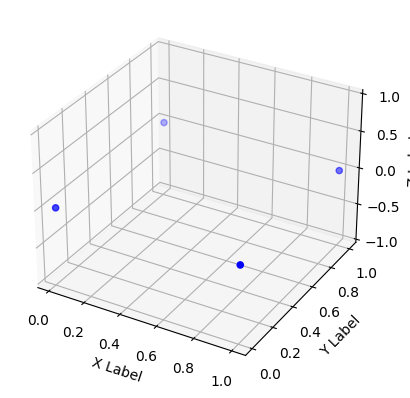

In [50]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, z coordinates
x = nominal_clusters[:, 0]
y = nominal_clusters[:, 1]
z = nominal_clusters[:, 2]

# Plot
ax.scatter(x, y, z, c='b', marker='o')

# Set labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [ ]:
# TODO: HERE MAYBE CAN BE USEFUL AN EXPERIMENT TO VALIDATE THE CLUSTERING SOLUTION

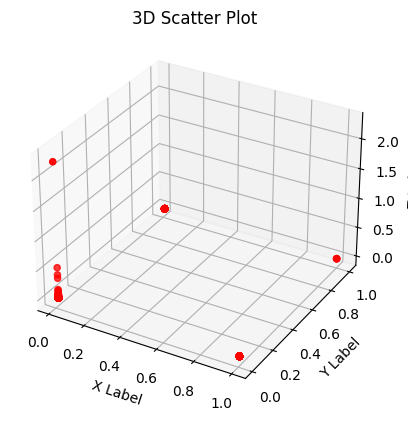

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract x, y, and z coordinates from theta_list
x_coords = [theta[0] for theta in theta_list]
y_coords = [theta[1] for theta in theta_list]
z_coords = [theta[2] for theta in theta_list]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(x_coords, y_coords, z_coords, c='r', marker='o')

# Set labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')

plt.show()

In [52]:
results = battery.build_results_table()
results = results['operations']

In [53]:
results.keys()

dict_keys(['time', 'soc', 'soh', 'voltage', 'current', 'power', 'Vocv', 'R0', 'R1', 'C', 'temperature', 'heat'])

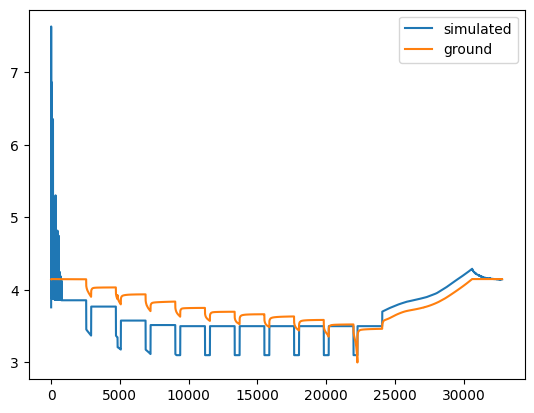

In [54]:
plt.plot(results['voltage'], label="simulated")
plt.plot(df['voltage'], label="ground")
plt.legend()